<a href="https://colab.research.google.com/github/areias/healthcare_fraud/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install wandb -qqq


     |████████████████████████████████| 1.7 MB 7.1 MB/s 
     |████████████████████████████████| 140 kB 53.3 MB/s 
     |████████████████████████████████| 97 kB 6.4 MB/s 
     |████████████████████████████████| 180 kB 61.4 MB/s 
     |████████████████████████████████| 63 kB 1.4 MB/s 


In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import wandb

In [4]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [5]:
df_ben=pd.read_csv('Train_Beneficiarydata-1542865627584.csv')
df_in=pd.read_csv('Train_Inpatientdata-1542865627584.csv')
df_out=pd.read_csv('Train_Outpatientdata-1542865627584.csv')
df=pd.read_csv('Train-1542865627584.csv')

In [6]:
df

,Provider,PotentialFraud
0,PRV51001,No
1,PRV51003,Yes
2,PRV51004,No
3,PRV51005,Yes
4,PRV51007,No
...,...,...
5405,PRV57759,No
5406,PRV57760,No
5407,PRV57761,No
5408,PRV57762,No


**Merging the data**

**Train**

In [15]:
df_in['Claim_type']='Inpatient'
df_out['Claim_type']='Outpatient'

In [16]:
final_df=pd.concat([df_in, df_out])
final_df=pd.merge(df_ben, final_df, on='BeneID')
final_df=pd.merge(final_df, df, on='Provider')

In [17]:
final_df.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,ClmDiagnosisCode_3,ClmDiagnosisCode_4,ClmDiagnosisCode_5,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,Claim_type,PotentialFraud
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,2,1,2,2,1,1,1,2,1,1,36000,3204,60,70,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,5853,7843,2768,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inpatient,Yes
1,BENE12511,1944-09-01,NaN,1,1,0,39,510,12,12,2,2,2,2,2,2,1,1,1,2,2,0,0,1250,90,CLM724430,2009-12-11,2009-12-11,PRV55912,600,PHY420794,NaN,NaN,NaN,NaN,0.0,NaN,NaN,V560,V4283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes
2,BENE14577,1935-10-01,NaN,2,1,Y,33,70,12,12,2,1,1,2,2,2,2,1,2,2,1,0,0,2390,440,CLM567180,2009-09-07,2009-09-07,PRV55912,20,PHY381733,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0401,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes
3,BENE15074,1932-06-01,NaN,2,1,0,39,470,12,12,1,2,1,2,2,2,1,1,2,2,2,0,0,870,210,CLM259984,2009-03-22,2009-03-22,PRV55912,30,PHY371570,NaN,PHY393406,NaN,NaN,0.0,NaN,NaN,V812,40390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes
4,BENE16973,1932-05-01,NaN,1,1,0,39,310,12,12,1,1,1,2,2,2,2,1,2,2,2,24000,2136,450,200,CLM565430,2009-09-06,2009-09-06,PRV55912,50,PHY365867,PHY327147,NaN,NaN,NaN,0.0,NaN,NaN,V7183,53081,78959,4280,E8788,78079,79902,25002,71848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes


In [9]:
final_df.shape

(558211, 55)

In [10]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 55 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BeneID                           558211 non-null  object 
 1   DOB                              558211 non-null  object 
 2   DOD                              4131 non-null    object 
 3   Gender                           558211 non-null  int64  
 4   Race                             558211 non-null  int64  
 5   RenalDiseaseIndicator            558211 non-null  object 
 6   State                            558211 non-null  int64  
 7   County                           558211 non-null  int64  
 8   NoOfMonths_PartACov              558211 non-null  int64  
 9   NoOfMonths_PartBCov              558211 non-null  int64  
 10  ChronicCond_Alzheimer            558211 non-null  int64  
 11  ChronicCond_Heartfailure         558211 non-null  int64  
 12  Ch

**Usage of the date variables:**

In [18]:
# Convert the column Date into Datetime64 datatype
final_df['ClaimStartDt'] = pd.to_datetime(final_df['ClaimStartDt'], format = '%Y-%m-%d')
final_df['ClaimEndDt'] = pd.to_datetime(final_df['ClaimEndDt'], format = '%Y-%m-%d')

In [19]:
final_df['ClaimDuration']= final_df['ClaimEndDt']-final_df['ClaimStartDt']

In [20]:
model_df=final_df[['IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'ClaimDuration', 'Claim_type', 'InscClaimAmtReimbursed', 'PotentialFraud']]

In [22]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 558211 entries, 0 to 558210
Data columns (total 8 columns):
 #   Column                    Non-Null Count   Dtype          
---  ------                    --------------   -----          
 0   IPAnnualReimbursementAmt  558211 non-null  int64          
 1   IPAnnualDeductibleAmt     558211 non-null  int64          
 2   OPAnnualReimbursementAmt  558211 non-null  int64          
 3   OPAnnualDeductibleAmt     558211 non-null  int64          
 4   ClaimDuration             558211 non-null  timedelta64[ns]
 5   Claim_type                558211 non-null  object         
 6   InscClaimAmtReimbursed    558211 non-null  int64          
 7   PotentialFraud            558211 non-null  object         
dtypes: int64(5), object(2), timedelta64[ns](1)
memory usage: 38.3+ MB


In [23]:
model_df['Claim_type']=pd.get_dummies(model_df['Claim_type'])
model_df['PotentialFraud']=pd.get_dummies(model_df['PotentialFraud'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [24]:
model_df['ClaimDuration'] = model_df['ClaimDuration'].dt.days

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [73]:
data = model_df.drop(['PotentialFraud'], axis=1)
target = model_df['PotentialFraud']
labels = map(lambda x: dict(enumerate(model_df['target_names']))[x], model_df['PotentialFraud'])

In [57]:
final_df['PotentialFraud'].value_counts()

No     345415
Yes    212796
Name: PotentialFraud, dtype: int64

In [54]:
target.value_counts()

1    345415
0    212796
Name: PotentialFraud, dtype: int64

**Splitting the data:**

In [43]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=15, stratify=target)

In [51]:
y_train.value_counts()

1    259061
0    159597
Name: PotentialFraud, dtype: int64

In [52]:
y_test.value_counts()

1    86354
0    53199
Name: PotentialFraud, dtype: int64

In [44]:
log_model = LogisticRegression(solver='liblinear', random_state=0)

In [45]:
log_model.fit(X_train, y_train)

LogisticRegression(random_state=0, solver='liblinear')

In [46]:
y_pred=log_model.predict(X_test)

In [47]:
pred_prob = log_model.predict_proba(X_test)
pred_prob

array([[0.5 , 0.5 ],
       [0.56, 0.44],
       [0.37, 0.63],
       ...,
       [0.37, 0.63],
       [0.37, 0.63],
       [0.36, 0.64]])

**Confusion Matrix:**

In [34]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Test states')
    plt.xlabel('Predicted states')
    plt.tight_layout()

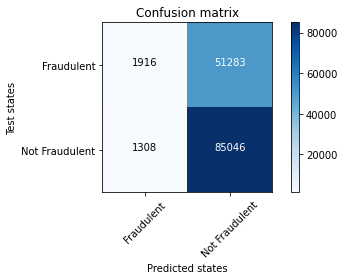

In [58]:
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Fraudulent', 'Not Fraudulent'],
                      title='Confusion matrix')

In [61]:
accuracy_score(y_test, y_pred)

0.6231467614454723

In [63]:
f1_score(y_test, y_pred)

0.7638301980842723

In [70]:
wandb.init(project="Healthcare_fraud")

In [71]:
wandb.sklearn.plot_confusion_matrix(y_test, y_pred)

In [79]:
wandb.sklearn.plot_classifier(log_model, X_train, X_test, y_train, y_test, y_pred, pred_prob, labels,
                                                         model_name='LR', , feature_names=None)

wandb: 
wandb: Plotting LR.
/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  "X does not have valid feature names, but"
wandb: Logged feature importances.


IndexError: ignored

In [ ]:
wandb.sklearn.plot_learning_curve(model, model_train, target)

In [ ]:
y_proba=model.predict_proba(model_train)
y_proba

array([[0.40576962, 0.59423038],
       [0.63311377, 0.36688623],
       [0.63304212, 0.36695788],
       ...,
       [0.41931585, 0.58068415],
       [0.42402954, 0.57597046],
       [0.42727237, 0.57272763]])

In [ ]:
wandb.sklearn.plot_roc(target, y_proba, target)

wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
wandb: WARNING wandb uses only the first 10000 datapoints to create the plots.
